In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import skimage.measure
import albumentations as A
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, UpSampling2D

In [2]:
# pip install tensorflow_addons

In [4]:
![[ ! -f data_scene_flow.zip ]] && wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_scene_flow.zip
![[ -f data_scene_flow.zip ]] && unzip -o -q data_scene_flow.zip

'[[' 不是内部或外部命令，也不是可运行的程序
或批处理文件。
'[[' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [3]:
kittiL = cv2.imread('training/image_2/000001_10.png')[:,:,::-1]
kittiDL = skimage.measure.block_reduce(cv2.imread('training/disp_noc_0/000001_10.png', 0), (8, 8), np.max)

TypeError: 'NoneType' object is not subscriptable

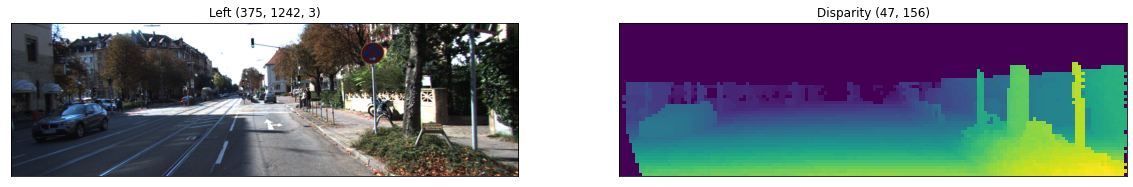

In [6]:
fig = plt.figure(figsize=(20,5))
plt.subplot(121),plt.imshow(kittiL),plt.title(f'Left {kittiL.shape}');
plt.subplot(122),plt.imshow(kittiDL),plt.title(f'Disparity {kittiDL.shape}');
plt.setp(fig.get_axes(), xticks=[], yticks=[]);

In [7]:
list_ds = tf.data.Dataset.list_files('training/image_2/*_10.png')

def process_path(file_path, seed):
    parts = tf.strings.split(file_path, os.sep)
    label_file = tf.strings.join([parts[0], 'disp_noc_0', parts[2]], os.sep)

    # Make a new seed so that random transformation is consistent between image
    # and label depth map
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
  
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [192, 640])
    image = tf.image.stateless_random_brightness(image, max_delta=0.3, seed=new_seed)
    image = tf.clip_by_value(image, 0, 1)
    image = tf.image.stateless_random_flip_left_right(image, seed=seed)
    image.set_shape((192, 640, 3))

    disp = tf.io.read_file(label_file)
    disp = tf.image.decode_png(disp)
    disp = tf.image.convert_image_dtype(disp, tf.float32)
    disp = tf.nn.max_pool2d(tf.expand_dims(disp, 0), (8, 8), 8, 'VALID')
    disp = tf.image.stateless_random_flip_left_right(disp, seed=seed)
    disp = tf.image.flip_left_right(disp)
    disp = tf.image.resize(disp, size=(48, 160))
    disp = tf.squeeze(disp)
    disp = disp * 255.0
    disp.set_shape((48, 160))

    rot_factor = tf.random.uniform(shape=[], minval=-7.0, maxval=7.0, dtype=tf.float32)
    angle = np.pi/180*rot_factor
    image = tfa.image.rotate(image, angle, fill_mode='nearest')
    disp = tfa.image.rotate(disp, angle, fill_mode='nearest')

    return image, disp


counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((list_ds, (counter, counter)))
validation_files = train_ds.take(10)
train_ds = train_ds.skip(10)

labeled_ds = train_ds.map(process_path, num_parallel_calls=4)
labeled_ds = labeled_ds.batch(32, drop_remainder=True).prefetch(buffer_size=32).repeat()

val_ds = validation_files.map(process_path).batch(5)

Instructions for updating:
Use `tf.data.Dataset.scan(...) instead


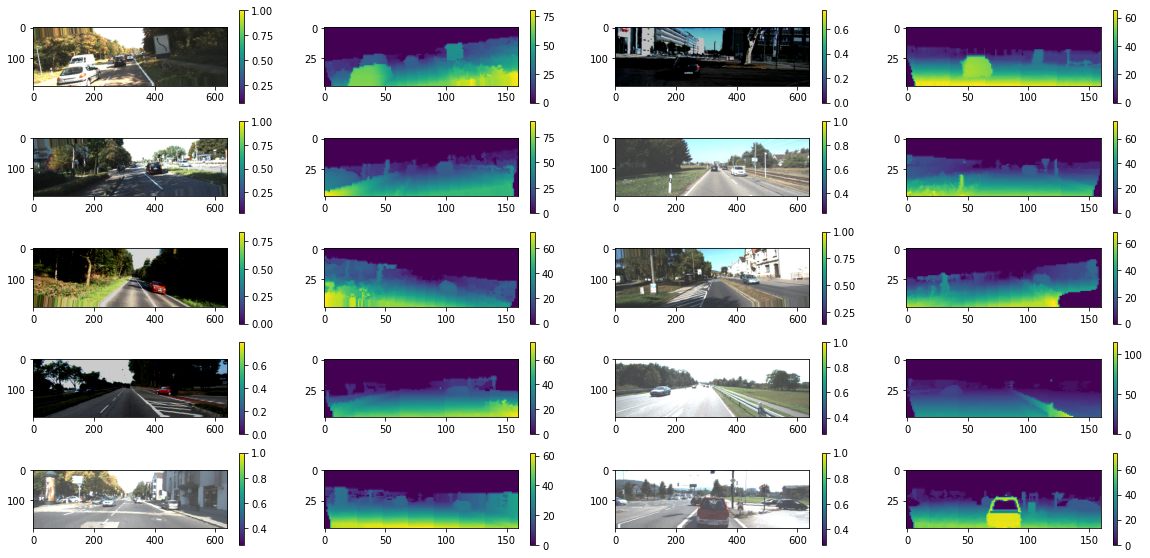

In [8]:
fig= plt.figure(figsize=(20, 20))
for i_f, f in enumerate(labeled_ds.take(1)):
    for i in range(10):
        plt.subplot(10,4,i_f*10 + 2*i + 1),plt.imshow(f[0][i].numpy()),plt.colorbar();
        plt.subplot(10,4,i_f*10 + 2*i + 2),plt.imshow(f[1][i].numpy()),plt.colorbar();

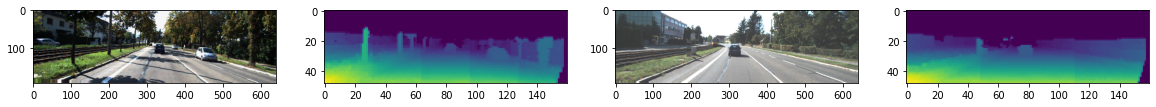

In [9]:
fig= plt.figure(figsize=(20, 20))
for i_f, f in enumerate(val_ds.take(1)):
    for i in range(2):
        plt.subplot(10,4,i_f*2 + 2*i + 1),plt.imshow(f[0][i].numpy());
        plt.subplot(10,4,i_f*2 + 2*i + 2),plt.imshow(f[1][i].numpy());

In [10]:
# 模型的建立
def make_model():
    inputs = keras.Input(shape=(192, 640, 3))

    # "Coarse" stream

    # encoder
    Coarse1_conv = keras.layers.Conv2D(96, (11, 11), (4, 4))(inputs)
    Coarse1_bn   = keras.layers.BatchNormalization()(Coarse1_conv)
    Coarse1_act  = keras.layers.ReLU()(Coarse1_bn)
    Coarse1      = keras.layers.MaxPool2D((2, 2))(Coarse1_act)

    Coarse2_conv = keras.layers.Conv2D(256, (5, 5), (2, 2))(Coarse1)
    Coarse2_bn   = keras.layers.BatchNormalization()(Coarse2_conv)
    Coarse2      = keras.layers.ReLU()(Coarse2_bn)

    Coarse3_conv = keras.layers.Conv2D(384, (3, 3))(Coarse2)
    Coarse3_bn   = keras.layers.BatchNormalization()(Coarse3_conv)
    Coarse3_act  = keras.layers.ReLU()(Coarse3_bn)
    Coarse3      = keras.layers.MaxPool2D((2, 2))(Coarse3_act)

    # decoder

    Coarse4_conv = keras.layers.Conv2DTranspose(256, (3, 3))(Coarse3)
    Coarse4_bn   = keras.layers.BatchNormalization()(Coarse4_conv)
    Coarse4_us   = keras.layers.UpSampling2D((2, 2))(Coarse4_bn)
    Coarse4      = keras.layers.ReLU()(Coarse4_us)

    Coarse5_conv = keras.layers.Conv2DTranspose(96, (3, 3), padding='same')(Coarse4)
    Coarse5_bn   = keras.layers.BatchNormalization()(Coarse5_conv)
    Coarse5_us   = keras.layers.UpSampling2D((2, 2))(Coarse5_bn)
    Coarse5      = keras.layers.ReLU()(Coarse5_us)

    Coarse6_conv = keras.layers.Conv2DTranspose(64, (3, 3), padding='same')(Coarse5)
    Coarse6_bn   = keras.layers.BatchNormalization()(Coarse6_conv)
    Coarse6_us   = keras.layers.UpSampling2D((2, 2))(Coarse6_bn)
    Coarse6      = keras.layers.ReLU()(Coarse6_us)

    # "Fine" stream
    Fine1_conv = keras.layers.Conv2D(64, (9, 9), (2, 2), padding='same')(inputs)
    Fine1_bn   = keras.layers.BatchNormalization()(Fine1_conv)
    Fine1_act  = keras.layers.ReLU()(Fine1_bn)
    Fine1      = keras.layers.MaxPool2D((2, 2))(Fine1_act)

    # add coarse output in ...
    Fine2_in   = tf.concat([Fine1, Coarse6], 3)
    Fine2_conv = keras.layers.Conv2D(64, (5, 5), padding='same')(Fine2_in)
    Fine2_bn   = keras.layers.BatchNormalization()(Fine2_conv)
    Fine2      = keras.layers.ReLU()(Fine2_bn)

    Fine3_conv = keras.layers.Conv2D(64, (5, 5), padding='same')(Fine2)
    Fine3_bn   = keras.layers.BatchNormalization()(Fine3_conv)
    Fine3      = keras.layers.ReLU()(Fine3_bn)

    Fine4      = keras.layers.Conv2D(1, (3, 3), activation='linear', padding='same')(Fine3)

    # padding to keep shape (48, 160)

    outputs = Fine4

    return keras.Model(inputs, outputs)


In [11]:
# 损失函数的定义
def eigen_2015_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=float)
    y_pred = tf.cast(y_pred, dtype=float)

    # Calculate d from y_true and y_pred
    # d = ...
    d = tf.where(tf.greater(y_true, 0), tf.math.log(y_true) - y_pred, tf.zeros_like(y_true))
    valid = tf.where(tf.greater(y_true, 0), True, False)
    
    # Get `n` from `y_true`. Don't forget to tf.cast to tf.float32
    # n = ...
    n = tf.math.count_nonzero(y_true, axis=[1, 2])
    n = tf.cast(n, float)
    
    # Calculate data term
    # data_term = ...
    data_term = tf.reduce_sum(tf.square(d), axis=[1, 2])
    data_term = tf.divide(data_term, n)
    
    # Calculate direction term
    # direction_term = ...
    direction_term = tf.reduce_sum(d, axis=[1, 2])
    direction_term = tf.square(direction_term)
    direction_term = -tf.divide(direction_term, 2 * tf.square(n))
    
    # Calculate gradient matching term
    # matching_term = ...

    d_di = d[:,1:,:] - d[:,:-1,:]
    d_dj = d[:,:,1:] - d[:,:,:-1]
    valid_di = tf.cast(tf.logical_and(valid[:,1:,:], valid[:,:-1,:]), float)
    valid_dj = tf.cast(tf.logical_and(valid[:,:,1:], valid[:,:,:-1]), float)
    ni = tf.reduce_sum(valid_di, axis=[1, 2])
    nj = tf.reduce_sum(valid_dj, axis=[1, 2])
    matching_term = tf.divide(tf.reduce_sum(valid_di * tf.square(d_di), axis=[1, 2]), ni) + tf.divide(tf.reduce_sum(valid_dj * tf.square(d_dj), axis=[1, 2]), nj)

    return data_term + direction_term + matching_term

In [12]:
epochs = 150
learning_rate = 1e-3

batchsize = 32

steps_per_epoch = 20

model = make_model()

model.summary()  # 输出模型参数 

model.compile(loss=eigen_2015_loss, optimizer=keras.optimizers.Adam(lr=learning_rate), metrics=['accuracy'])


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 640, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 158, 96)  34944       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 46, 158, 96)  384         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 46, 158, 96)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# 模型训练
callbacks = keras.callbacks.ModelCheckpoint(filepath='save_best.h5', verbose=1, save_best_only=True)

history = model.fit(labeled_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=val_ds, callbacks=callbacks, verbose=1, shuffle=True)


Epoch 1/150
20/20 [==============================] - 59s 1s/step - loss: 1.6228 - accuracy: 0.2530 - val_loss: 239.0227 - val_accuracy: 0.3849

Epoch 00001: val_loss improved from inf to 239.02266, saving model to save_best.h5
Epoch 2/150
20/20 [==============================] - 26s 1s/step - loss: 0.6313 - accuracy: 0.1645 - val_loss: 30.5746 - val_accuracy: 0.3743

Epoch 00002: val_loss improved from 239.02266 to 30.57464, saving model to save_best.h5
Epoch 3/150
20/20 [==============================] - 26s 1s/step - loss: 0.6171 - accuracy: 0.1546 - val_loss: 3.0849 - val_accuracy: 0.3758

Epoch 00003: val_loss improved from 30.57464 to 3.08492, saving model to save_best.h5
Epoch 4/150
20/20 [==============================] - 26s 1s/step - loss: 0.5973 - accuracy: 0.1510 - val_loss: 2.1476 - val_accuracy: 0.3095

Epoch 00004: val_loss improved from 3.08492 to 2.14759, saving model to save_best.h5
Epoch 5/150
20/20 [==============================] - 26s 1s/step - loss: 0.5825 - accur